In [4]:
#!pip install opencv-python

In [1]:
import os, glob, cv2, shutil, joblib,gc, random, re
import tensorflow as tf
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime
from sklearn.model_selection import train_test_split, KFold
from sklearn import metrics
import random
import warnings
warnings.filterwarnings(action='ignore')
import datetime
print(datetime.datetime.today())

2022-11-07 11:23:25.381416


In [2]:
def video_gray2rgb(df):
    out=np.zeros(df.shape[:3]+(3,),dtype='u1')
    for i in range(df.shape[0]):
        img=cv2.cvtColor(df[i,:,:,0],cv2.COLOR_GRAY2RGB)
        out[i,:,:,:]=img   
        del img
    return out
def batch_avi(data,idx,BATCH_SIZE=1024,
              font=cv2.FONT_HERSHEY_SIMPLEX):
    
    def label_vis(data,i,font):
        input_img=cv2.cvtColor(
            data[i,:,:,0],cv2.COLOR_GRAY2RGB).astype('u1')
        pred_img=cv2.cvtColor(
            data[i,:,:,1]*255,cv2.COLOR_GRAY2RGB).astype('u1')
        pred_img[:,:,(0,2)]=0
        
        label_img=cv2.addWeighted(input_img,1,pred_img,.2,0)
        text=f"Index : {i}"
        cv2.putText(label_img,text, (80,30),font,1,(255,0,0),2)
        
        return np.expand_dims(label_img,axis=0)
    return np.concatenate(
        [label_vis(data,i, font) 
         for i in range(
             (BATCH_SIZE*idx),(np.min([data.shape[0],(idx+1)*BATCH_SIZE])))])

def write_avi(data,file_name,fps=30):
    fourcc = cv2.VideoWriter_fourcc(*"DIVX")
    (width, height)=data.shape[1:3]
    out = cv2.VideoWriter(file_name, fourcc, fps, (height, width),isColor=True)
    for i in range(len(data)):
        out.write(data[i])
    out.release()
    
def my_confusion_matrix(y_true,y_pred,cutoff=.5):
    label_true=y_true>=.5
    pred_true=y_pred>=cutoff
    label_false= ~ label_true
    pred_false = ~ pred_true
    tp=np.sum(label_true&pred_true)
    fn=np.sum(label_true)-tp
    fp=np.sum(label_false&pred_true)
    tn=np.sum(label_false)-fp
    return tp,fn,fp,tn


def read_avi(file):
    data=list()
    cap = cv2.VideoCapture(file)
    while(cap.isOpened()):
        ret, frame = cap.read()
        if ret:
            frame=cv2.resize(frame,(320,240))
            frame=np.expand_dims(frame, axis=0)
            data.append(frame)
            cv2.waitKey(1)
        else:
            break
    cap.release()
    cv2.destroyAllWindows()
    return np.concatenate(data).astype('u1')

In [3]:
files=glob.glob(
    "/root/lustre/data/vHIT/s3/final/final_20221101_count/1.Dataset/**/**/SN/*.tsv")+\
    glob.glob(
        "/root/lustre/data/vHIT/s3/final/final_20221101_count/1.Dataset/**/**/video/**/*.tsv")
files=[i for i in files if not re.compile("verified.tsv").findall(i) \
       if re.compile("anonymized").findall(i)]

In [4]:
if not "label_df.csv" in os.listdir():
    avis=list();label1=list();label2=list()
    for file in tqdm(files):
        df = pd.read_csv(f"/root/{os.path.realpath(file)}", sep ='\t')
        video_list = (df[df.blink=='O'][
            ['frame_number','horizontal','vertical']].values)
        for frame, h, v in video_list:
            avi_files=glob.glob(f"{os.path.dirname(file)}/*frame_{frame}-*.avi")
            if len(avi_files)!=1:
                raise
            avi_file=avi_files[0]
            if type(v)!=str:
                v='mid'
            if type(h)!=str:
                h='mid'
            avis.append(avi_file)
            label1.append(h)
            label2.append(v)
    label_zip=zip(avis,label1,label2)
    label_df=pd.DataFrame({"avi":avis,"y1":label1,"y2":label2})
    label_df["idx"]=label_df.index

    label_df.to_csv("label_df.csv",index=False)
label_df=pd.read_csv("label_df.csv")

In [5]:
feature_extractor = tf.keras.applications.InceptionV3(
    weights="imagenet",
    include_top=False,
    pooling="avg",
    input_shape=(240, 320, 3),
)
preprocess_input = tf.keras.applications.inception_v3.preprocess_input

inp=tf.keras.layers.Input((240,320,3))
pre_inp=preprocess_input(inp)
out=feature_extractor(pre_inp)
with tf.device("/cpu:0"):
    feature_model=tf.keras.Model(inp,out)
    feature_model.trainable=False
    
def feature_gen(file,i):
    img=np.zeros((125,240,320,3),dtype='u1')
    avi_img=read_avi(f"/root/{os.path.realpath(file)}")
    img[:avi_img.shape[0],:,:,:]=avi_img
    with tf.device("/cpu:0"):
        mm[i,:,:]=feature_model(img).numpy()
        mm.flush()

2022-11-07 11:24:52.303685: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-07 11:24:52.828917: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 46723 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:3b:00.0, compute capability: 8.6


In [10]:
# mm=np.memmap('/root/data/nia_data_dir/동영상제작/feature.npy',mode='w+',
#              shape=(label_df.shape[0],125,2048),dtype='float32')
# for (file,y1,y2,i) in tqdm(label_df.values):
#     img=np.zeros((125,240,320,3),dtype='u1')
#     avi_img=read_avi(f"/root/{os.path.realpath(file)}")
#     img[:avi_img.shape[0],:,:,:]=avi_img
#     with tf.device("/gpu:0"):
#         mm[i,:,:]=feature_model(img).numpy()
#         mm.flush()

  0% 0/214987 [00:00<?, ?it/s]2022-11-07 11:27:35.902817: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8200
2022-11-07 11:27:38.243646: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


INFO:tensorflow:Assets written to: ram://e3e7f657-3ed4-4abe-afb2-5c9da914e268/assets


100% 214987/214987 [37:08:27<00:00,  1.61it/s]   


# 모델링

## 모델 확인

In [ ]:
mm=np.memmap('/root/data/nia_data_dir/동영상제작/feature.npy',mode='r',
             shape=(label_df.shape[0],125,2048),dtype='float32')

In [11]:
def my_generator(label_df):
    def generator():
        for (file,y1,y2,idx) in label_df.values:
            out1=mm[idx]
            out2=np.zeros(3);out3=np.zeros(3)
            
            if y1=='left':
                out2[0]=1
            elif y1=='mid':
                out2[1]=1
            elif y1=='right':
                out2[2]=1
            
            if y2=='up':
                out3[0]=1
            elif y2=='mid':
                out3[1]=1
            elif y2=='down':
                out3[2]=1
            yield out1,(out2,out3)
    return generator

In [13]:
def my_rnn_model():
    tf.keras.backend.clear_session()
    tf.random.set_seed(42)

    inputs = tf.keras.Input((125,2048))
    x1=tf.keras.layers.GRU(64, return_sequences=True)(inputs)
    x1=tf.keras.layers.GRU(16)(x1)
    x1=tf.keras.layers.Dropout(.3)(x1)
    x1=tf.keras.layers.Dense(512)(x1)
    x1=tf.keras.layers.Dense(3,activation='softmax',name='output1')(x1)

    x2=tf.keras.layers.GRU(64, return_sequences=True)(inputs)
    x2=tf.keras.layers.GRU(16)(x2)
    x2=tf.keras.layers.Dropout(.3)(x2)
    x2=tf.keras.layers.Dense(256)(x2)
    x2=tf.keras.layers.Dense(3,activation='softmax',name='output2')(x2)
    rnn_model=tf.keras.Model(inputs,[x1,x2])
    return rnn_model


In [ ]:
kf = KFold(n_splits = 3, shuffle = False)
output_type='float32';output_shape=(125,2048)
target_label1=np.array(['left','mid','right'])
target_label2=np.array(['up','mid','down'])

tp_sum=dict();fn_sum=dict();fp_sum=dict();tn_sum=dict()
for K, (train_idx,test_idx) in enumerate(kf.split(label_df),1):
    
    for cutoff in np.arange(0,1.1,0.05):
        for out_type in [0,1]:
            if out_type==0:
                target_label=target_label1
            else:
                target_label=target_label2
            for target in target_label:
                cond=f"K_{K}_out_type_{out_type}_target_{target}_cutoff_{cutoff:.02f}"
                tp_sum[cond]=0;fn_sum[cond]=0;fp_sum[cond]=0;tn_sum[cond]=0
    
    train_files=label_df.loc[train_idx]
    test_files=label_df.loc[test_idx]
    train_files, valid_files=train_test_split(
        train_files, test_size=.2, random_state=42)
    train_files=train_files.sample(
        frac=1,random_state=42).reset_index().drop('index',axis=1)
    
    random.seed(42)
    tr_dataset=tf.data.Dataset.from_generator(
        my_generator(train_files),
        output_shapes=(output_shape, (3, 3)),
        output_types=(output_type, (output_type, output_type)))

    random.seed(42)
    te_dataset=tf.data.Dataset.from_generator(
        my_generator(test_files),
        output_shapes=(output_shape, (3, 3)),
        output_types=(output_type, (output_type, output_type)))
    random.seed(42)
    val_dataset=tf.data.Dataset.from_generator(
        my_generator(valid_files),
        output_shapes=(output_shape, (3, 3)),
        output_types=(output_type, (output_type, output_type)))

    tr_gen =tr_dataset.batch(256).prefetch(1)
    te_gen =te_dataset.batch(1).prefetch(1)
    val_gen=val_dataset.batch(256).prefetch(1)

    tf.keras.backend.clear_session()
    tf.random.set_seed(42)
    model=my_rnn_model()
    model.compile(
        optimizer=tf.keras.optimizers.Adam(
            learning_rate=.05),
        loss={"output1":'categorical_crossentropy', 
              "output2":'categorical_crossentropy'},
        metrics={"output1":'accuracy',
                 "output2":'accuracy'},
    )
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
                monitor='val_loss', patience=20,
            mode='min'),
            tf.keras.callbacks.ReduceLROnPlateau(
                monitor='val_loss',patience=10,factor=0.1,
            mode='min')
    ]
    model.fit(tr_gen, epochs=500, validation_data=val_gen,
              verbose=1,callbacks=callbacks)
    model.save(f'cnn_rnn_model_{K}_fold.h5')    
#     ###################
#     """
#     모델 검증
#     """
    for i,(x,y) in tqdm(enumerate(te_gen)):
        for target in range(3):
            for out_type in [0,1]:
                if out_type==0:
                    target_label=target_label1
                else:
                    target_label=target_label2

                y_true=y[out_type][:,target].numpy()
                y_pred=model.predict(x)[out_type][:,target].astype('float64')
                for cutoff in np.arange(0,1.1,0.05):
                    cond=f"K_{K}_out_type_{out_type}_target_{target_label[target]}_cutoff_{cutoff:.02f}"
                    tp,fn,fp,tn=my_confusion_matrix(y_true,y_pred,cutoff)
                    # tn,fn,fp,tp=confusion_matrix(y_true,y_pred,cutoff=cutoff)
                    tp_sum[cond]+=tp;fn_sum[cond]+=fn;fp_sum[cond]+=fp;tn_sum[cond]+=tn

Epoch 1/500
448/448 [==============================] - 4041s 9s/step - loss: 1.9375 - output1_loss: 0.9778 - output2_loss: 0.9597 - output1_accuracy: 0.4788 - output2_accuracy: 0.4639 - val_loss: 1.7059 - val_output1_loss: 0.8167 - val_output2_loss: 0.8892 - val_output1_accuracy: 0.4728 - val_output2_accuracy: 0.4793 - lr: 0.0500
Epoch 2/500
448/448 [==============================] - 2856s 6s/step - loss: 1.7134 - output1_loss: 0.8228 - output2_loss: 0.8907 - output1_accuracy: 0.4865 - output2_accuracy: 0.4706 - val_loss: 1.7011 - val_output1_loss: 0.8112 - val_output2_loss: 0.8898 - val_output1_accuracy: 0.4728 - val_output2_accuracy: 0.4793 - lr: 0.0500
Epoch 3/500
448/448 [==============================] - 2728s 6s/step - loss: 17.5899 - output1_loss: 16.6976 - output2_loss: 0.8923 - output1_accuracy: 0.4767 - output2_accuracy: 0.4717 - val_loss: 3.6450 - val_output1_loss: 2.7569 - val_output2_loss: 0.8881 - val_output1_accuracy: 0.4971 - val_output2_accuracy: 0.4793 - lr: 0.0500
Ep

71663it [8:55:18,  2.23it/s]


Epoch 1/500
448/448 [==============================] - 1938s 4s/step - loss: 1.9259 - output1_loss: 0.9526 - output2_loss: 0.9733 - output1_accuracy: 0.4839 - output2_accuracy: 0.4689 - val_loss: 1.7271 - val_output1_loss: 0.8337 - val_output2_loss: 0.8934 - val_output1_accuracy: 0.4782 - val_output2_accuracy: 0.4533 - lr: 0.0500
Epoch 2/500
448/448 [==============================] - 1511s 3s/step - loss: 1.7112 - output1_loss: 0.8195 - output2_loss: 0.8917 - output1_accuracy: 0.4860 - output2_accuracy: 0.4710 - val_loss: 1.7178 - val_output1_loss: 0.8250 - val_output2_loss: 0.8928 - val_output1_accuracy: 0.4782 - val_output2_accuracy: 0.4533 - lr: 0.0500
Epoch 3/500
448/448 [==============================] - 1507s 3s/step - loss: 16.7122 - output1_loss: 15.8073 - output2_loss: 0.9050 - output1_accuracy: 0.4797 - output2_accuracy: 0.4728 - val_loss: 41.7394 - val_output1_loss: 40.8444 - val_output2_loss: 0.8950 - val_output1_accuracy: 0.4782 - val_output2_accuracy: 0.4533 - lr: 0.0500


71662it [11:34:54,  1.72it/s]


Epoch 1/500
448/448 [==============================] - 3596s 8s/step - loss: 1.8796 - output1_loss: 0.9074 - output2_loss: 0.9723 - output1_accuracy: 0.4843 - output2_accuracy: 0.4663 - val_loss: 1.7145 - val_output1_loss: 0.8219 - val_output2_loss: 0.8927 - val_output1_accuracy: 0.4898 - val_output2_accuracy: 0.4837 - lr: 0.0500
Epoch 2/500
448/448 [==============================] - 3090s 7s/step - loss: 9.5045 - output1_loss: 8.6102 - output2_loss: 0.8943 - output1_accuracy: 0.4771 - output2_accuracy: 0.4706 - val_loss: 1.7129 - val_output1_loss: 0.8255 - val_output2_loss: 0.8874 - val_output1_accuracy: 0.4760 - val_output2_accuracy: 0.4837 - lr: 0.0500
Epoch 3/500
448/448 [==============================] - 3585s 8s/step - loss: 1.7694 - output1_loss: 0.8697 - output2_loss: 0.8997 - output1_accuracy: 0.4855 - output2_accuracy: 0.4694 - val_loss: 1.7145 - val_output1_loss: 0.8198 - val_output2_loss: 0.8947 - val_output1_accuracy: 0.4898 - val_output2_accuracy: 0.4837 - lr: 0.0500
Epoc

In [ ]:
# tpr=dict();fpr=dict()
# for K in range(1,4):
#     tpr[K]=list();fpr[K]=list()    
#     for i in np.arange(0,1.1,.05):
#         tp=0;fn=0;fp=0
#         for target in target_label:
#             tp+=tp_sum[f"K_{K}_target_{target}_cutoff_{i:.02f}"]
#             fn+=fn_sum[f"K_{K}_target_{target}_cutoff_{i:.02f}"]
#             fp+=fp_sum[f"K_{K}_target_{target}_cutoff_{i:.02f}"]
#             tn+=tn_sum[f"K_{K}_target_{target}_cutoff_{i:.02f}"]
#         tpr[K].append(tp/(tp+fn))
#         fpr[K].append(fp/(fp+tn))
        
#     tpr[K]=np.array(tpr[K]);fpr[K]=np.array(fpr[K])

In [7]:
joblib.dump([tp_sum,fn_sum,fp_sum,tn_sum],'수평수직지표.pkl')
from itertools import cycle
import matplotlib.pyplot as plt 
import numpy as np
import joblib
from sklearn import metrics
# tp_sum,fn_sum,fp_sum,tn_sum=joblib.load('수평수직지표.pkl')

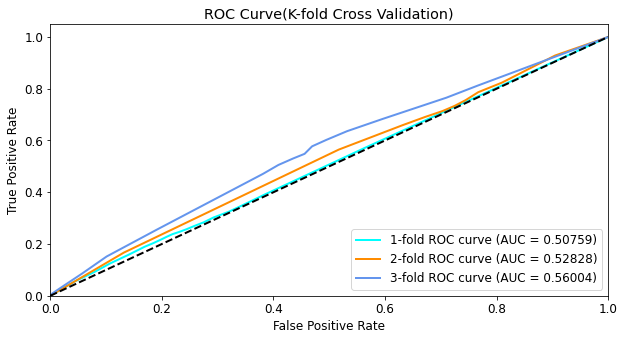

In [9]:
target="left";out_type=0
tpr=dict();fpr=dict()
for K in range(1,4):
    tpr[K]=list();fpr[K]=list()    
    for i in np.arange(0,1.1,.05):
        tpr[K].append(tp_sum[f"K_{K}_out_type_{out_type}_target_{target}_cutoff_{i:.02f}"]/(
            tp_sum[f"K_{K}_out_type_{out_type}_target_{target}_cutoff_{i:.02f}"]+\
            fn_sum[f"K_{K}_out_type_{out_type}_target_{target}_cutoff_{i:.02f}"]))
        fpr[K].append(fp_sum[f"K_{K}_out_type_{out_type}_target_{target}_cutoff_{i:.02f}"]/(
            fp_sum[f"K_{K}_out_type_{out_type}_target_{target}_cutoff_{i:.02f}"]+\
            tn_sum[f"K_{K}_out_type_{out_type}_target_{target}_cutoff_{i:.02f}"]))
    tpr[K]=np.array(tpr[K]);fpr[K]=np.array(fpr[K])
    
plt.figure()
plt.rcParams['figure.figsize'] = [10,5]
plt.rcParams.update({'font.size': 12})
colors = cycle(["aqua", "darkorange", "cornflowerblue"])
lw=2
for K,color in zip(range(1,4),colors):
    roc_auc=metrics.auc(fpr[K],tpr[K])
    plt.plot(
        fpr[K],
        tpr[K],
        label=f"{K}-fold ROC curve (AUC = {roc_auc:0.5f})",
        color=color,
        lw=lw
    )
plt.plot([0, 1], [0, 1], "k--", lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve(K-fold Cross Validation)")
plt.legend(loc="lower right")
plt.show()